## Comparison to existing limits

This notebook reads the CSVs defined in Limits_calc.ipynb and compares them against other experiments.
Functions are also included to compare variants of the limit (such as the final limit vs KDAR-only limits)

This is very similar to Comaparison_plot.ipynb, but uses ALP reweighted limits instead.

In [38]:
#Loading libraries
import os
import json
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pyhf
import scipy
from scipy import stats
import uproot3
import uproot
import math
import awkward as ak
import pickle
import csv
import copy
import pandas as pd
from particle import Particle

import decay_widths as dw
from importlib import reload

print("Successful!")

### Some root paths used by different users/devices
#     root_dir = "../../For_David/" for the default root directory used by David
#     root_dir = "/exp/uboone/data/users/jbateman/workdir/HPS_uboone_analysis/" # Filepath used on the FNAL cluster.
#     root_dir = "/Users/user/PhD/HPS_uboone_analysis/" # A filepath used for local running.
root_dir = "/exp/uboone/data/users/jbateman/workdir/HPS_uboone_analysis/"

Successful!


First the limit files are loaded from limit_files/, which should exist within the location specified as root_dir. This contains all the comparison limits, as well as the RW_Brazil_plot/ folder, which holds the limits set in the Limits_calc.ipynb notebook.

In [44]:
cols = ['Mass','Value']

def Get_sigma_bands(filename, root_path = root_dir, RW = False):
    """
    Load sigma bands for each mass point from .csv files saved above.
    Filename is without the decay type or .csv
    """
    to_load_names = ["exp_1sig_up","exp_1sig_down","exp_2sig_up","exp_2sig_down","exp_limit","obs_limit"]
    loaded_lists = []
    for i, name in enumerate(to_load_names):
        if RW:
            full_path = root_path+f"limit_files/RW_Brazil_plot/{name}_{filename}.csv"
        else:
            full_path = root_path+f"limit_files/Brazil_plot/{name}_{filename}.csv"
        if(os.path.exists(full_path)):
            with open(full_path, "r") as fp:   # Unpickling
                reader = csv.reader(fp)
                loaded_list = list(reader)
                loaded_lists.append(loaded_list)
                
    return loaded_lists

def convert_g_to_c(g):
    s2w = 0.223 
    m_W = Particle.from_pdgid(24).mass
    e = 0.303

    g2_muw = e**2/s2w
    v = m_W /g2_muw
    f_a = 1e6 # MeV, energy scale (1 TeV, used in https://arxiv.org/pdf/2202.03447.pdf)
    return g *f_a/v

def convert_c_to_g(c):
    s2w = 0.223 
    m_W = Particle.from_pdgid(24).mass
    e = 0.303

    g2_muw = e**2/s2w
    v = m_W /g2_muw
    f_a = 1e6 # MeV, energy scale (1 TeV, used in https://arxiv.org/pdf/2202.03447.pdf)
    return c *v/f_a

def get_interpolated_vals(df, num_points):
    
    x = df['Mass']
    y = df['Value']
    logx = np.log10(x)
    logy = np.log10(y)

    logx_vals_wanted = np.linspace(np.min(logx), np.max(logx), num_points)
    logy_interp = np.interp(logx_vals_wanted, logx, logy)

    x_vals_wanted = 10**logx_vals_wanted
    y_interp = 10**logy_interp

    d = {'Mass': x_vals_wanted, 'Value': y_interp}

    return d

# Loading limits set using Limits_calc.ipynb
uboone_ALP = pd.read_csv(root_dir+"limit_files/RW_Brazil_plot/obs_limit_ALL_Capped_HPS_rebinned_limit.csv",names=cols)
uboone_ALP_run1 = pd.read_csv(root_dir+"limit_files/RW_Brazil_plot/obs_limit_Run1_Capped_HPS_rebinned_limit.csv",names=cols)
uboone_ALP_run3 = pd.read_csv(root_dir+"limit_files/RW_Brazil_plot/obs_limit_Run3_Capped_HPS_rebinned_limit.csv",names=cols)
uboone_ALP_KDAR_run1 = pd.read_csv(root_dir+"limit_files/RW_Brazil_plot/obs_limit_KDAR_Run1_Capped_HPS_rebinned_limit.csv",names=cols)

# Loading limits set by other experiments
NA62_k_pi_100MeV = pd.read_csv("limit_files/na62_k_pi_limit_100MeV.csv",names=cols)
NA62_k_pi_1GeV = pd.read_csv("limit_files/na62_k_pi_limit_1GeV.csv",names=cols)
NA62_pi0_100MeV = pd.read_csv("limit_files/na62_p0_100MeV.csv",names=cols)

e949_100MeV = pd.read_csv("limit_files/e949_100MeV.csv",names=cols)
e949_150MeV = pd.read_csv("limit_files/e949_150MeV.csv",names=cols)

ub_theory_c = pd.read_csv("limit_files/theorist_uB_c.csv",names=cols)
ub_theory_g = pd.read_csv("limit_files/theorist_uB_g.csv",names=cols)

ub_projection_c = pd.read_csv("limit_files/ub_Coloma_Projection.csv",names=cols)

charm_beam_dump_1GeV = pd.read_csv("limit_files/charm_beam_dump_1GeV.csv",names=cols)
# charm_beam_dump_1GeV= pd.DataFrame(get_interpolated_vals(charm_beam_dump_1GeV,10000))


In [45]:

def set_undefined_limits(df, file_name_str, val):

    exp = pd.read_csv(root_dir+"limit_files/RW_Brazil_plot/exp_limit_"+file_name_str,names=cols)
    sig_up = pd.read_csv(root_dir+"limit_files/RW_Brazil_plot/exp_1sig_up_"+file_name_str,names=cols)
    sig_down = pd.read_csv(root_dir+"limit_files/RW_Brazil_plot/exp_1sig_down_"+file_name_str,names=cols)

    df_value = df["Value"].copy()  # Ensure we don't modify the original DataFrame
    df_value[np.where((exp["Value"] == sig_up["Value"]) & (exp["Value"] == sig_down["Value"]))] = 100000 # Use a large number, rather than inf, to keep the curve continuous

    df["Value"] = df_value

    return df
    
uboone_ALP = set_undefined_limits(uboone_ALP, "ALL_Capped_HPS_rebinned_limit.csv", 100000)
uboone_ALP_run1 = set_undefined_limits(uboone_ALP_run1, "Run1_Capped_HPS_rebinned_limit.csv", 100000)
uboone_ALP_run3 = set_undefined_limits(uboone_ALP_run3, "Run3_Capped_HPS_rebinned_limit.csv", 100000)
uboone_ALP_KDAR_run1 = set_undefined_limits(uboone_ALP_KDAR_run1, "KDAR_Run1_Capped_HPS_rebinned_limit.csv", 100000)

/tmp/ipykernel_4126661/1318833784.py:101: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


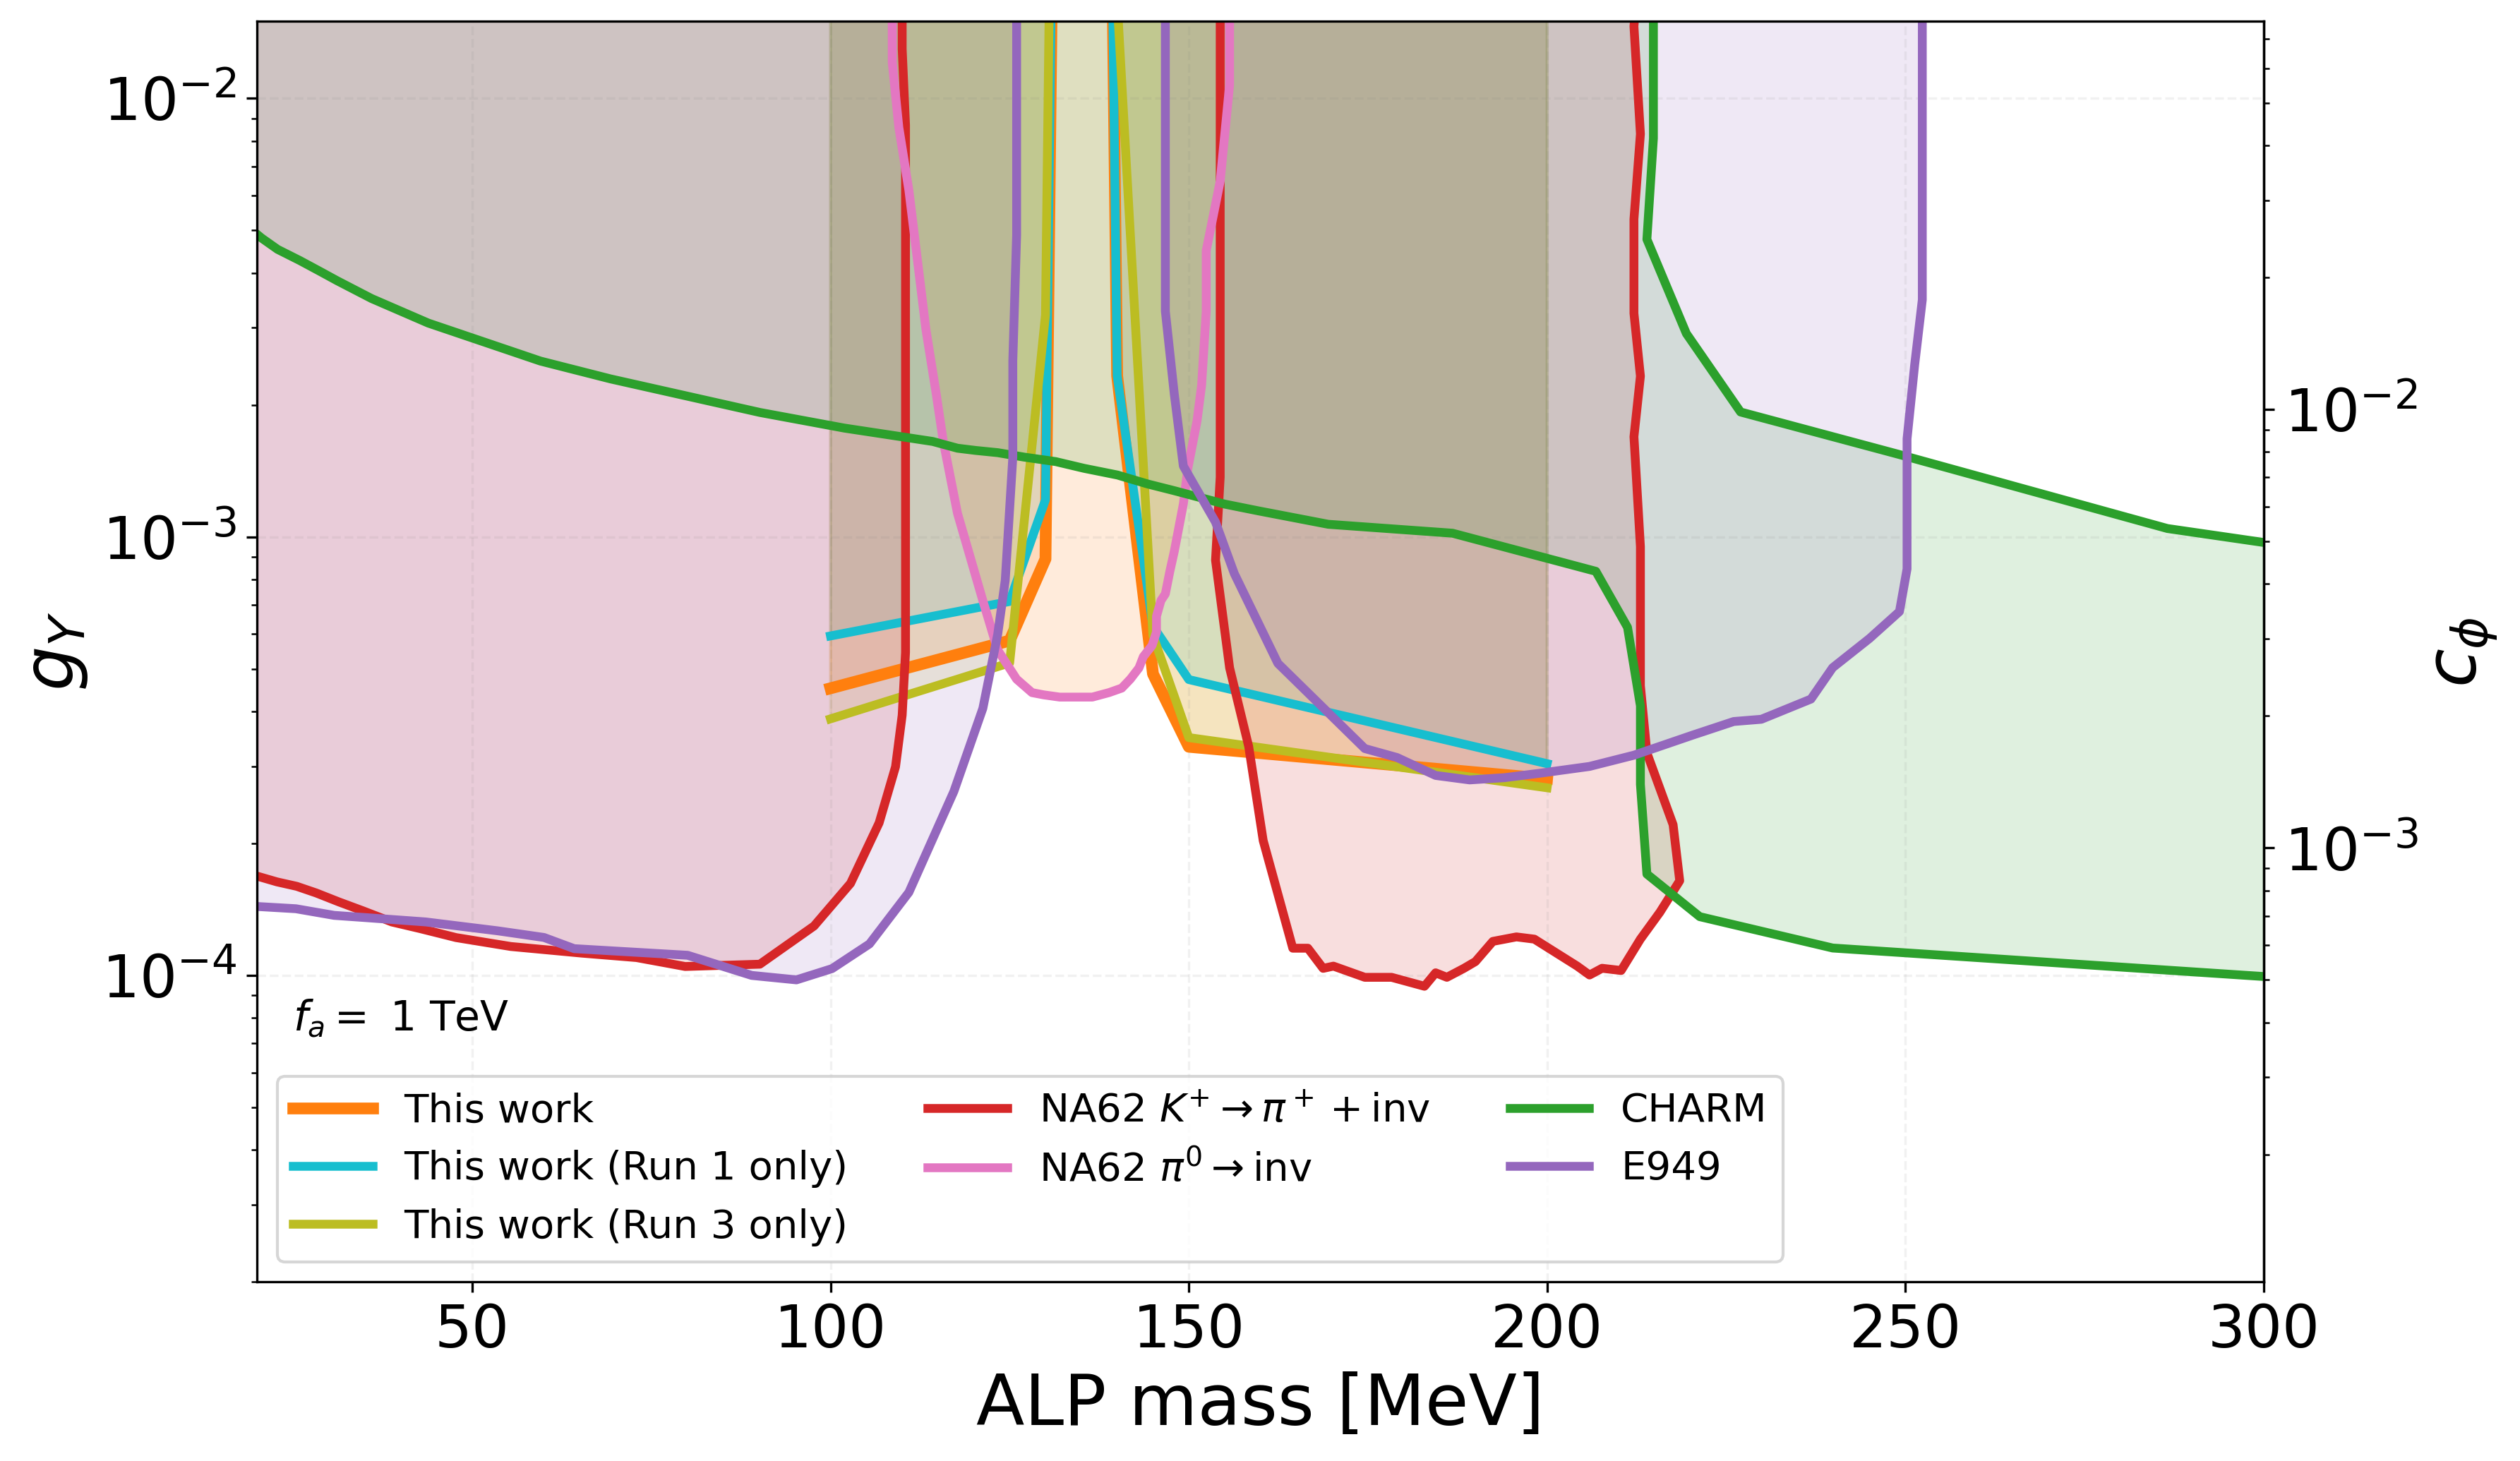

In [46]:

fig, ax1 = plt.subplots(figsize=(12,7),facecolor='white',dpi=300)

plot_coloma = False

#"This work ($7.01\times10^{20}$ POT)"
ax1.plot(uboone_ALP['Mass'],convert_c_to_g(uboone_ALP['Value']),label=r"This work",color="C1",lw=4)
ax1.fill_between(uboone_ALP['Mass'],convert_c_to_g(uboone_ALP['Value']), 1, color="C1",alpha=0.15)

ax1.plot(uboone_ALP_run1['Mass'],convert_c_to_g(uboone_ALP_run1['Value']),label=r"This work (Run 1 only)",color="C9",lw=3)
ax1.fill_between(uboone_ALP_run1['Mass'],convert_c_to_g(uboone_ALP_run1['Value']), 1, color="C9",alpha=0.15)

# ax1.plot(uboone_ALP_run3['Mass'],convert_c_to_g(uboone_ALP_run3['Value']),label=r"This work (Run 3 only)",color="C8",lw=3)
# ax1.fill_between(uboone_ALP_run3['Mass'],convert_c_to_g(uboone_ALP_run3['Value']), 1, color="C8",alpha=0.15)

# ax1.plot(uboone_ALP_KDAR_run1['Mass'],convert_c_to_g(uboone_ALP_KDAR_run1['Value']),label=r"This work (Run 1 KDAR only)",color="C7",lw=3)
# ax1.fill_between(uboone_ALP_KDAR_run1['Mass'],convert_c_to_g(uboone_ALP_KDAR_run1['Value']), 1, color="C7",alpha=0.15)



# ALP limit set by Coloma et al.
if plot_coloma:
    # Need to split the limit into two parts, M<125 MeV and M>144 MeV
    theory_sub_125 = ub_theory_g[ub_theory_g['Mass']<0.125] 
    theory_sup_144 = ub_theory_g[ub_theory_g['Mass']>0.144] 

    ax1.plot(theory_sub_125['Mass']*1000,theory_sub_125['Value'],label=r"Coloma et al.",color="C0",lw=3)
    ax1.fill_between(theory_sub_125['Mass']*1000,theory_sub_125['Value'], 1, color="C0",alpha=0.15)

    ax1.plot(theory_sup_144['Mass']*1000,theory_sup_144['Value'],color="C0",lw=3)
    ax1.fill_between(theory_sup_144['Mass']*1000,theory_sup_144['Value'], 1, color="C0",alpha=0.15)


# Other limits
ax1.plot(NA62_k_pi_100MeV['Mass']*1000,NA62_k_pi_100MeV['Value'],label=r"NA62 $K^{+}\rightarrow\pi^++$inv",color="C3",lw=3)
ax1.fill_between(NA62_k_pi_100MeV['Mass']*1000,NA62_k_pi_100MeV['Value'],1,color="C3",alpha=0.15)

ax1.plot(NA62_k_pi_1GeV['Mass']*1000,NA62_k_pi_1GeV['Value'],color="C3",lw=3)
ax1.fill_between(NA62_k_pi_1GeV['Mass']*1000,NA62_k_pi_1GeV['Value'],1,color="C3",alpha=0.15)

ax1.plot(NA62_pi0_100MeV['Mass']*1000, NA62_pi0_100MeV['Value'],label=r"NA62 $\pi^0\rightarrow$inv",color="C6",lw=3)
ax1.fill_between(NA62_pi0_100MeV['Mass']*1000, NA62_pi0_100MeV['Value'], 1, color="C1",alpha=0.15)

ax1.plot(charm_beam_dump_1GeV['Mass']*1000,charm_beam_dump_1GeV['Value'],label=r"CHARM",color="C2",lw=3)
ax1.fill_between(charm_beam_dump_1GeV['Mass']*1000,charm_beam_dump_1GeV['Value'], 1, color="C2",alpha=0.15)

ax1.plot(e949_100MeV['Mass']*1000,e949_100MeV['Value'],label=r"E949",color="C4",lw=3)
ax1.fill_between(e949_100MeV['Mass']*1000,e949_100MeV['Value'],1,color="C4",alpha=0.15)

ax1.plot(e949_150MeV['Mass']*1000,e949_150MeV['Value'],color="C4",lw=3)
ax1.fill_between(e949_150MeV['Mass']*1000,e949_150MeV['Value'],1,color="C4",alpha=0.15)

# ax1.axvspan(125, 145, alpha=1, color='grey',lw=0, label=r'$a-\pi^0$ Excluded Region')
# ax1.plot([135,135],[1e-5,1e-2],color='grey',lw=24)


ylims = [2e-5,1.5e-2]
# ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim(20,300)
ax1.set_ylim(ylims[0],ylims[-1])

ax1.set_xlabel(r'ALP mass [MeV]',fontsize=24)
# ax1.yaxis.tick_right()
ax1.set_ylabel(r'$g_Y$',fontsize=24)
ax1.yaxis.set_label_position("left")
secay = ax1.secondary_yaxis('right', functions=(convert_g_to_c, convert_c_to_g))

size = 14
ax1.text(25,0.75e-4, rf'$f_a =$ 1 TeV',fontsize=size)
# $7.01\times10^{20}$ POT
# ax1.text(245, 0.75e-4, r"$7.01\times10^{20}$ POT",fontsize=size)

ax1.legend(prop={'size': 13.5}, loc="lower left",ncol=3).set_zorder(20)
ax1.grid(ls='--',color='C7',alpha=0.1)
ax1.tick_params(axis='x', labelsize=20)
ax1.tick_params(axis='y', labelsize=20)
secay.tick_params(axis='y', labelsize=20)
secay.set_ylabel(r'$c_\phi$',fontsize=24)
fig.tight_layout()



start = 125
width = 20
rect = patches.Rectangle((start,1.01*ylims[0]),width,0.99*ylims[-1],facecolor='lightgrey',fill=True,zorder=19, edgecolor='grey', ls='', label=r'$a-\pi^0$ Excluded Region')
# ax1.add_patch(rect)


ax1.set_ylim(2e-5,1.5e-2)


name = f"ALP_limit_comparison_plot"

savefig = input(f"Do you want to save the figure as {name}? y/n")

if savefig == "y":
    fig.savefig(root_dir+'Plots/Limits/'+name+'.pdf',bbox_inches='tight', pad_inches=0.3)
    fig.savefig(root_dir+'Plots/Limits/'+name+'.png',bbox_inches='tight', pad_inches=0.3)


fig.show()

In [47]:
def Get_sigma_bands(filename, root_path = root_dir, RW = False):
    """
    Load sigma bands for each mass point from .csv files saved above.
    Filename is without the decay type or .csv
    """
    to_load_names = ["exp_1sig_up","exp_1sig_down","exp_2sig_up","exp_2sig_down","exp_limit","obs_limit"]
    loaded_lists = []
    for i, name in enumerate(to_load_names):
        if RW:
            full_path = root_path+f"limit_files/RW_Brazil_plot/{name}_{filename}.csv"
        else:
            full_path = root_path+f"limit_files/Brazil_plot/{name}_{filename}.csv"
        if(os.path.exists(full_path)):
            with open(full_path, "r") as fp:   # Unpickling
                reader = csv.reader(fp)
                loaded_list = list(reader)
                loaded_lists.append(loaded_list)
                
    return loaded_lists

def Make_dicts_for_limits(loaded_lists):
    """
    Takes output of Get_sigma_bands and translates to dict with HNL masses as keys.
    """
    to_load_names = ["exp_1sig_up","exp_1sig_down","exp_2sig_up","exp_2sig_down","exp_limit","obs_limit"]
    lims_dict = {}
    for i, exp_lim_list in enumerate(loaded_lists[0]):
        # if isinstance(exp_lim_list[0], str):
        HNL_mass = int(exp_lim_list[0])
        # else: HNL_mass = exp_lim_list[0]
        individual_lims = {}
        for j, lims in enumerate(loaded_lists):
            individual_lims[to_load_names[j]] = float(loaded_lists[j][i][1])
        lims_dict[int(HNL_mass)] = individual_lims
    
    return lims_dict

def Make_list_limits(loaded_lists):
    """
    Takes output of Get_sigma_bands and translates to dict with lists of limit vals.
    """
    to_load_names = ["exp_1sig_up","exp_1sig_down","exp_2sig_up","exp_2sig_down","exp_limit","obs_limit"]
    lims_dict = {}
    for i, exp_lim_list in enumerate(loaded_lists):
        lims_list, mass_list = [], []
        for j, val in enumerate(exp_lim_list):
            lims_list.append(float(val[1]))
            mass_list.append(int(val[0]))
        
        lims_dict[to_load_names[i]] = lims_list
    
    return lims_dict, mass_list



def compare_limits(data_types, limit_to_compare, data_labels = [], use_observed = True):
    """
    data_types = array of length 2, containing the data prefix, such as 'ALL', 'stat_ALL', 'Run1', etc. 
    limit_to_compare = string of the defining which limit to compare between the two data_types
    """

    cols = ['Mass','Value']
    root_file = "_Capped_HPS_rebinned_limit"
    
    filenames = [f"{data_type}{root_file}" for data_type in data_types]

    

    REWEIGHTING = False

    limits_arr = []
    for filename in filenames:
        ee_loaded_test = Get_sigma_bands(filename, RW=REWEIGHTING)
        ee_limits_dict = Make_dicts_for_limits(ee_loaded_test)

        ee_lims_dict, ee_mass_list = Make_list_limits(ee_loaded_test)
        limits_arr.append([ee_lims_dict, ee_mass_list])


    lengths = [len(limit[1]) for limit in limits_arr]
    
    if lengths.count(lengths[0]) != len(lengths):
        if len(lengths) == 2:
            print("The mass lists are not the same length, attempting to match mass points.")

            limits_arr[0], limits_arr[1] = match_mass_points(limits_arr[0], limits_arr[1]) 
            
            
            if len(limits_arr[0][1]) != len(limits_arr[1][1]):
                print("Trying with a smaller subset of mass points.")
                limits_arr[0], limits_arr[1] = match_mass_points(limits_arr[0], limits_arr[1]) 
                if len(limits_arr[0][1]) != len(limits_arr[1][1]):
                    print("Mass points matching was unsuccessful.")
                    return
            
            print("Mass points matched successfully.")

        else:
            print("The mass lists are not the same length, try reducing the number of limits compared.")
        



    titlename = r"MicroBooNE Data $7.01\times10^{20}$ POT"

    fig,ax = plt.subplots(nrows=2, ncols=1, sharex=True, gridspec_kw={'height_ratios': [3, 1]}, figsize=(14,14),dpi=100)
    plt.sca(ax[0])

    colours = [
        ['black','red', 'yellow', 'lightgreen'],
        ['blue','orange', 'lightblue', 'lightcoral'],
        ['violet', 'green', 'lightgreen', 'pink'],
    ]
    i=0
    for ee_lims_dict, ee_mass_list in limits_arr:
        if len(data_labels) == 0:
            data = data_types[i]
        elif len(data_labels) == len(limits_arr):
            data = ""
        else: 
            print("Label arr length should match data types length.\nRunning with default labels.")
            data = data_types[i]

        HNL_masses=ee_mass_list

        plt.plot(HNL_masses,np.array(ee_lims_dict['obs_limit']),lw=4,ls='-',marker='o',color=colours[i][0],label=data+' Observed')
        plt.plot(HNL_masses,np.array(ee_lims_dict['exp_limit']),lw=2,ls='--',color=colours[i][1],label=data+' Expected')
        plt.fill_between(HNL_masses,np.array(ee_lims_dict['exp_1sig_down']),np.array(ee_lims_dict['exp_1sig_up']),color=colours[i][2],label=data+r' Exp. 1$\sigma$',alpha=0.5)
        plt.fill_between(HNL_masses,np.array(ee_lims_dict['exp_2sig_down']),np.array(ee_lims_dict['exp_2sig_up']),color=colours[i][3],label=data+r' Exp. 2$\sigma$',alpha=0.5)
        
        i+=1

    plt.ylabel(r'$\theta$ Limit at 95% CL',fontsize=28)
    plt.xlabel('HPS Mass [MeV]',fontsize=28)


    # plt.text(0.99,0.95,r'MicroBooNE NuMI POT:$7.01\times 10^{20}$',fontsize=20,color='black',alpha=1,verticalalignment='top',horizontalalignment='right',transform=plt.gca().transAxes)
    plt.tick_params(axis='x', labelsize=24)
    plt.tick_params(axis='y', labelsize=24, which="major", length=10)
    plt.tick_params(axis='y', labelsize=24, which="minor", length=6)
    plt.ylim(5e-5,1e-3)
    # plt.xlim(0,250)
    plt.yscale('log')


   
    if len(data_labels) == 2:
            h, l = ax[0].get_legend_handles_labels()
            data = ""
            ph = [plt.plot([],marker="", ls="")[0]]*2
            handles = ph + h
            
            # handles = ph[:1] + h[::2] + ph[1:] + h[1::2]
            # labels = [labels[0]] + l[::2] + [labels[1]] + l[1::2]

            n = len(h) // 2

            # Rearrange the handles and labels
            handles = ph[:1] + h[:n-2] + h[n-2:n] + ph[1:] + h[n:-2] + h[-2:]
            # ['flux scaled', ' Exp. 1$\\sigma$', ' Exp. 2$\\sigma$', ' Observed', ' Expected', 'standard', ' Exp. 1$\\sigma$', ' Exp. 2$\\sigma$', ' Observed', ' Expected']
            labels = [data_labels[0]] + l[:n-2] + l[n-2:n] + [data_labels[1]] + l[n:-2] + l[-2:]
            
            leg = plt.legend(handles, labels, loc="upper right", ncol=len(limits_arr), frameon=False, fontsize=int(22*2/len(limits_arr)), prop={'size': int(24*2/len(limits_arr))}, title=titlename, title_fontsize=24)

            for vpack in leg._legend_handle_box.get_children():
                for hpack in vpack.get_children()[:1]:
                    hpack.get_children()[0].set_width(0)
    elif len(data_labels) > 2:
        print("More than 2 labels is not currently supported.")
        plt.legend(loc="upper right",ncol=len(limits_arr),frameon=False,fontsize=int(22*2/len(limits_arr)))
        if titlename != "": plt.legend(loc="upper right", ncol=len(limits_arr), frameon=False, fontsize=int(22*2/len(limits_arr)), prop={'size': int(24*2/len(limits_arr))}, title=titlename, title_fontsize=24)
    else:
        plt.legend(loc="upper right",ncol=len(limits_arr),frameon=False,fontsize=int(22*2/len(limits_arr)))
        if titlename != "": plt.legend(loc="upper right", ncol=len(limits_arr), frameon=False, fontsize=int(22*2/len(limits_arr)), prop={'size': int(24*2/len(limits_arr))}, title=titlename, title_fontsize=24)




    # plt.fill_betweenx(x,y,where=(x>2) & (x<=3), color='b')
    plt.tight_layout()

    plt.sca(ax[1])
    
    baseline_limit = limits_arr[0][0][limit_to_compare]
    
    for j in range(1,len(limits_arr)):

        limit_ratio = np.divide(limits_arr[j][0][limit_to_compare],baseline_limit)
        min_lim = np.min(limit_ratio)
        max_lim = 1+(1-min_lim)

        if len(HNL_masses) == 8:
            bin_widths = [45,5,5,5,5,5,5,95]

        if len(HNL_masses) == 3:
            bin_widths = [50,50,50]

        x_new = []
        y_new = []

        for i, width in enumerate(bin_widths):
            x_new.append(HNL_masses[i]-width/2)
            x_new.append(HNL_masses[i]+width/2)

            y_new.append(limit_ratio[i])
            y_new.append(limit_ratio[i])
        
        if len(data_labels) == 2:
            plt.plot(x_new, y_new, color=colours[j][0], label=data_labels[j])
        else:
            plt.plot(x_new, y_new, color=colours[j][0], label=data_types[j])   


    if len(data_labels) == 2:
        plt.plot(x_new, np.ones(len(x_new)), color='black', ls='--', label="Baseline ({})".format(data_labels[0]))
    else:
        plt.plot(x_new, np.ones(len(x_new)), color='black', ls='--', label="Baseline ({})".format(data_types[0]))

    plt.legend(loc="right", frameon=False, fontsize=int(22*2/len(limits_arr)), prop={'size': int(24*2/len(limits_arr))})
    if limit_to_compare == 'exp_limit':
        limit_label = 'Expected'
    elif limit_to_compare == 'obs_limit':
        limit_label = 'Observed'
    elif limit_to_compare == 'exp_1sig_up':
        limit_label = 'Expected 1$\sigma$ up'
    elif limit_to_compare == 'exp_1sig_down':
        limit_label = 'Expected 1$\sigma$ down'
    elif limit_to_compare == 'exp_2sig_up':
        limit_label = 'Expected 2$\sigma$ up'
    elif limit_to_compare == 'exp_2sig_down':
        limit_label = 'Expected 2$\sigma$ down'



    
    if len(data_labels) != 2:
        plt.ylabel('{} limits ratio '.format(limit_label),fontsize=20)
    else:
        plt.ylabel('{} limits ratio'.format(limit_label), fontsize=20)
    # plt.ylim(min_lim,max_lim)
    plt.xlim(np.min(HNL_masses),np.max(HNL_masses))

    savefig = input("Do you want to save the figures? y/n ")

    savename = "{}_{}_limit_comparison".format(data_types[0], data_types[1])

    if savefig == "y":
        plt.savefig(root_dir+'Plots/Limits/'+savename+'.pdf',bbox_inches='tight', pad_inches=0.3)
        plt.savefig(root_dir+'Plots/Limits/'+savename+'.png',bbox_inches='tight', pad_inches=0.3)

        
        
def match_mass_points(input_1, input_2):

    if len(input_1[1]) > len(input_2[1]):
        input_1, input_2 = input_2, input_1
        swapped = True
    else: swapped = False

    new_dict = {}
    new_arr = []
    

    keys = input_1[0].keys()

    for key in keys:
        new_dict[key] = []

    for i, mass in enumerate(input_2[1]):
        if mass in input_1[1]:
            new_arr.append(mass)
            for key in keys:
                new_dict[key].append(input_2[0][key][i])



    # for i,key in enumerate(input_2[0]):
    #     print(input_1[1])
    #     print(input_2[1][i])
    #     if input_2[1][i] in input_1[1]:
    #         new_dict[key]=input_2[0][key]
    #         new_arr.append(input_2[1][i])

    # print(new_arr)

    input_2 = [new_dict, new_arr]

    if not swapped:
        return input_1, input_2
    else:
        return input_2, input_1

In [48]:

def compare_limits(data_types, limit_to_compare, data_labels = [], use_observed = True, skip_index = None):
    """
    data_types = array of length 2, containing the data prefix, such as 'ALL', 'stat_ALL', 'Run1', etc. 
    limit_to_compare = string of the defining which limit to compare between the two data_types
    """

    cols = ['Mass','Value']
    root_file = "_Capped_HPS_rebinned_limit"
    
    filenames = [f"{data_type}{root_file}" for data_type in data_types]

    

    REWEIGHTING = True

    limits_arr = []
    for filename in filenames:
        ee_loaded_test = Get_sigma_bands(filename, RW=REWEIGHTING)
        ee_limits_dict = Make_dicts_for_limits(ee_loaded_test)

        ee_lims_dict, ee_mass_list = Make_list_limits(ee_loaded_test)
        limits_arr.append([ee_lims_dict, ee_mass_list])


    lengths = [len(limit[1]) for limit in limits_arr]
    
    if lengths.count(lengths[0]) != len(lengths):
        if len(lengths) == 2:
            print("The mass lists are not the same length, attempting to match mass points.")

            limits_arr[0], limits_arr[1] = match_mass_points(limits_arr[0], limits_arr[1]) 
            
            
            if len(limits_arr[0][1]) != len(limits_arr[1][1]):
                print("Trying with a smaller subset of mass points.")
                limits_arr[0], limits_arr[1] = match_mass_points(limits_arr[0], limits_arr[1]) 
                if len(limits_arr[0][1]) != len(limits_arr[1][1]):
                    print("Mass points matching was unsuccessful.")
                    return
            
            print("Mass points matched successfully.")

        else:
            print("The mass lists are not the same length, try reducing the number of limits compared.")
        



    titlename = r"MicroBooNE Data $7.01\times10^{20}$ POT"

    fig,ax = plt.subplots(nrows=2, ncols=1, sharex=True, gridspec_kw={'height_ratios': [3, 1]}, figsize=(14,14),dpi=100)
    plt.sca(ax[0])

    colours = [
        ['black','red', 'yellow', 'lightgreen'],
        ['blue','orange', 'lightblue', 'lightcoral'],
        ['violet', 'green', 'lightgreen', 'pink'],
    ]

    


    i=0
    for ee_lims_dict, ee_mass_list in limits_arr:
        if len(data_labels) == 0:

            label = data_types[i]
            if "TEST_" in label:
                label = label.replace("TEST_","")
            if "ALL" in label:
                label = label.replace("ALL","")
            if "Test_" in label:
                label = label.replace("Test_","")
            data = label
        elif len(data_labels) == len(limits_arr):
            data = ""
        else: 
            print("Label arr length should match data types length.\nRunning with default labels.")
            data = data_types[i]

        HNL_masses=np.array(ee_mass_list)
        if skip_index != None:
            plt.plot(HNL_masses[:skip_index],np.array(ee_lims_dict['obs_limit'])[:skip_index],lw=4,ls='-',marker='o',color=colours[i][0],label=data+' Observed')
            plt.plot(HNL_masses[:skip_index],np.array(ee_lims_dict['exp_limit'])[:skip_index],lw=2,ls='--',color=colours[i][1],label=data+' Expected')
            plt.fill_between(HNL_masses[:skip_index],np.array(ee_lims_dict['exp_1sig_down'])[:skip_index],np.array(ee_lims_dict['exp_1sig_up'])[:skip_index],color=colours[i][2],label=data+r' Exp. 1$\sigma$',alpha=0.5)
            plt.fill_between(HNL_masses[:skip_index],np.array(ee_lims_dict['exp_2sig_down'])[:skip_index],np.array(ee_lims_dict['exp_2sig_up'])[:skip_index],color=colours[i][3],label=data+r' Exp. 2$\sigma$',alpha=0.5)
            
            plt.axvspan(HNL_masses[skip_index]-5, HNL_masses[skip_index]+5, alpha=1, color='grey')

            plt.plot(HNL_masses[skip_index+1:],np.array(ee_lims_dict['obs_limit'])[skip_index+1:],lw=4,ls='-',marker='o',color=colours[i][0])
            plt.plot(HNL_masses[skip_index+1:],np.array(ee_lims_dict['exp_limit'])[skip_index+1:],lw=2,ls='--',color=colours[i][1])
            plt.fill_between(HNL_masses[skip_index+1:],np.array(ee_lims_dict['exp_1sig_down'])[skip_index+1:],np.array(ee_lims_dict['exp_1sig_up'])[skip_index+1:],color=colours[i][2],alpha=0.5)
            plt.fill_between(HNL_masses[skip_index+1:],np.array(ee_lims_dict['exp_2sig_down'])[skip_index+1:],np.array(ee_lims_dict['exp_2sig_up'])[skip_index+1:],color=colours[i][3],alpha=0.5)
            

        i+=1

    plt.ylabel(r'$c_{\phi}$ Limit at 95% CL',fontsize=28)
    plt.xlabel('ALP Mass [MeV]',fontsize=28)


    # plt.text(0.99,0.95,r'MicroBooNE NuMI POT:$7.01\times 10^{20}$',fontsize=20,color='black',alpha=1,verticalalignment='top',horizontalalignment='right',transform=plt.gca().transAxes)
    plt.tick_params(axis='x', labelsize=24)
    plt.tick_params(axis='y', labelsize=24, which="major", length=10)
    plt.tick_params(axis='y', labelsize=24, which="minor", length=6)
    plt.ylim(1e-4,1e-1)
    # plt.xlim(0,250)
    plt.yscale('log')


   
    if len(data_labels) == 2:
            h, l = ax[0].get_legend_handles_labels()
            data = ""
            ph = [plt.plot([],marker="", ls="")[0]]*2
            handles = ph + h
            
            # handles = ph[:1] + h[::2] + ph[1:] + h[1::2]
            # labels = [labels[0]] + l[::2] + [labels[1]] + l[1::2]

            n = len(h) // 2

            # Rearrange the handles and labels
            handles = ph[:1] + h[:n-2] + h[n-2:n] + ph[1:] + h[n:-2] + h[-2:]
            # ['flux scaled', ' Exp. 1$\\sigma$', ' Exp. 2$\\sigma$', ' Observed', ' Expected', 'standard', ' Exp. 1$\\sigma$', ' Exp. 2$\\sigma$', ' Observed', ' Expected']
            labels = [data_labels[0]] + l[:n-2] + l[n-2:n] + [data_labels[1]] + l[n:-2] + l[-2:]
            
            leg = plt.legend(handles, labels, loc="upper right", ncol=len(limits_arr), frameon=False, fontsize=int(20*2/len(limits_arr)), prop={'size': int(24*2/len(limits_arr))}, title=titlename, title_fontsize=24)

            for vpack in leg._legend_handle_box.get_children():
                for hpack in vpack.get_children()[:1]:
                    hpack.get_children()[0].set_width(0)
    elif len(data_labels) > 2:
        print("More than 2 labels is not currently supported.")
        plt.legend(loc="upper right",ncol=len(limits_arr),frameon=False,fontsize=int(20*2/len(limits_arr)))
        if titlename != "": plt.legend(loc="upper right", ncol=len(limits_arr), frameon=False, fontsize=int(20*2/len(limits_arr)), prop={'size': int(20*2/len(limits_arr))}, title=titlename, title_fontsize=24)
    else:
        plt.legend(loc="upper right",ncol=len(limits_arr),frameon=False,fontsize=int(20*2/len(limits_arr)))
        if titlename != "": plt.legend(loc="upper right", ncol=len(limits_arr), frameon=False, fontsize=int(20*2/len(limits_arr)), prop={'size': int(20*2/len(limits_arr))}, title=titlename, title_fontsize=24)




    # plt.fill_betweenx(x,y,where=(x>2) & (x<=3), color='b')
    plt.tight_layout()

    plt.sca(ax[1])
    
    baseline_limit = limits_arr[0][0][limit_to_compare]
    
    if limit_to_compare == 'obs_limit':
        limit_label = 'Observed'
        colour_index = 0
    elif limit_to_compare == 'exp_limit':
        limit_label = 'Expected'
        colour_index = 1
    elif limit_to_compare == 'exp_1sig_up':
        limit_label = 'Expected 1$\sigma$ up'
        colour_index = 2
    elif limit_to_compare == 'exp_1sig_down':
        limit_label = 'Expected 1$\sigma$ down'
        colour_index = 2
    elif limit_to_compare == 'exp_2sig_up':
        limit_label = 'Expected 2$\sigma$ up'
        colour_index = 3
    elif limit_to_compare == 'exp_2sig_down':
        limit_label = 'Expected 2$\sigma$ down'
        colour_index = 3

    for j in range(1,len(limits_arr)):

        limit_ratio = np.divide(limits_arr[j][0][limit_to_compare],baseline_limit)
        min_lim = np.min(limit_ratio)
        max_lim = 1+(1-min_lim)

        if len(HNL_masses) == 8:
            bin_widths = [45,5,5,5,5,5,5,95]

        if len(HNL_masses) == 3:
            bin_widths = [50,50,50]

        x_new = []
        y_new = []

        for i, width in enumerate(bin_widths):
            x_new.append(HNL_masses[i]-width/2)
            x_new.append(HNL_masses[i]+width/2)

            y_new.append(limit_ratio[i])
            y_new.append(limit_ratio[i])
        
        if len(data_labels) == 2:
            plt.plot(x_new, y_new, color=colours[j][colour_index], label=data_labels[j])
        else:
            label = data_types[j]
            if "TEST_" in label:
                label = label.replace("TEST_","")
            if "ALL" in label:
                label = label.replace("ALL","")
            if "Test_" in label:
                label = label.replace("Test_","")
            plt.plot(x_new, y_new, color=colours[j][colour_index], label=label)
        
        print(limit_ratio)
        if np.max(y_new) - np.min(y_new) < 0.01:
            
            y_mean = np.mean(y_new)
            plt.ylim(y_mean-0.01,y_mean+0.01)



    if len(data_labels) == 2:
        plt.plot(x_new, np.ones(len(x_new)), color=colours[0][colour_index], ls='--', label="Baseline ({})".format(data_labels[0]))
    else:
        label = data_types[0]
        if "TEST_" in label:
            label = label.replace("TEST_","")
        if "ALL" in label:
            label = label.replace("ALL","")
        if "Test_" in label:
            label = label.replace("Test_","")
        if len(label) == 0:
            label = 'Full dataset'
        
        plt.plot(x_new, np.ones(len(x_new)), color=colours[0][colour_index], ls='--', label="Baseline ({})".format(label))

    plt.legend(loc="right", frameon=False, fontsize=int(22*2/len(limits_arr)), prop={'size': int(24*2/len(limits_arr))})

    
    


    
    if len(data_labels) != 2:
        plt.ylabel('{} limits ratio '.format(limit_label),fontsize=20)
    else:
        plt.ylabel('{} limits ratio'.format(limit_label), fontsize=20)
    # plt.ylim(min_lim,max_lim)
    plt.xlim(np.min(HNL_masses),np.max(HNL_masses))

    savefig = input("Do you want to save the figures? y/n ")

    savename = "{}_{}_limit_comparison".format(data_types[0], data_types[1])

    if savefig == "y":
        plt.savefig(root_dir+'Plots/Limits/'+savename+'.pdf',bbox_inches='tight', pad_inches=0.3)
        plt.savefig(root_dir+'Plots/Limits/'+savename+'.png',bbox_inches='tight', pad_inches=0.3)

        
        
def match_mass_points(input_1, input_2):

    if len(input_1[1]) > len(input_2[1]):
        input_1, input_2 = input_2, input_1
        swapped = True
    else: swapped = False

    new_dict = {}
    new_arr = []
    

    keys = input_1[0].keys()

    for key in keys:
        new_dict[key] = []

    for i, mass in enumerate(input_2[1]):
        if mass in input_1[1]:
            new_arr.append(mass)
            for key in keys:
                new_dict[key].append(input_2[0][key][i])

    input_2 = [new_dict, new_arr]

    if not swapped:
        return input_1, input_2
    else:
        return input_2, input_1

[1.3408043  1.29275656 1.19312979 1.         1.0000796  1.22387216
 1.29353193 1.22925372]
[0.86777122 0.87232817 2.25676671 1.         7.18130701 1.22387216
 1.06079347 0.94949291]


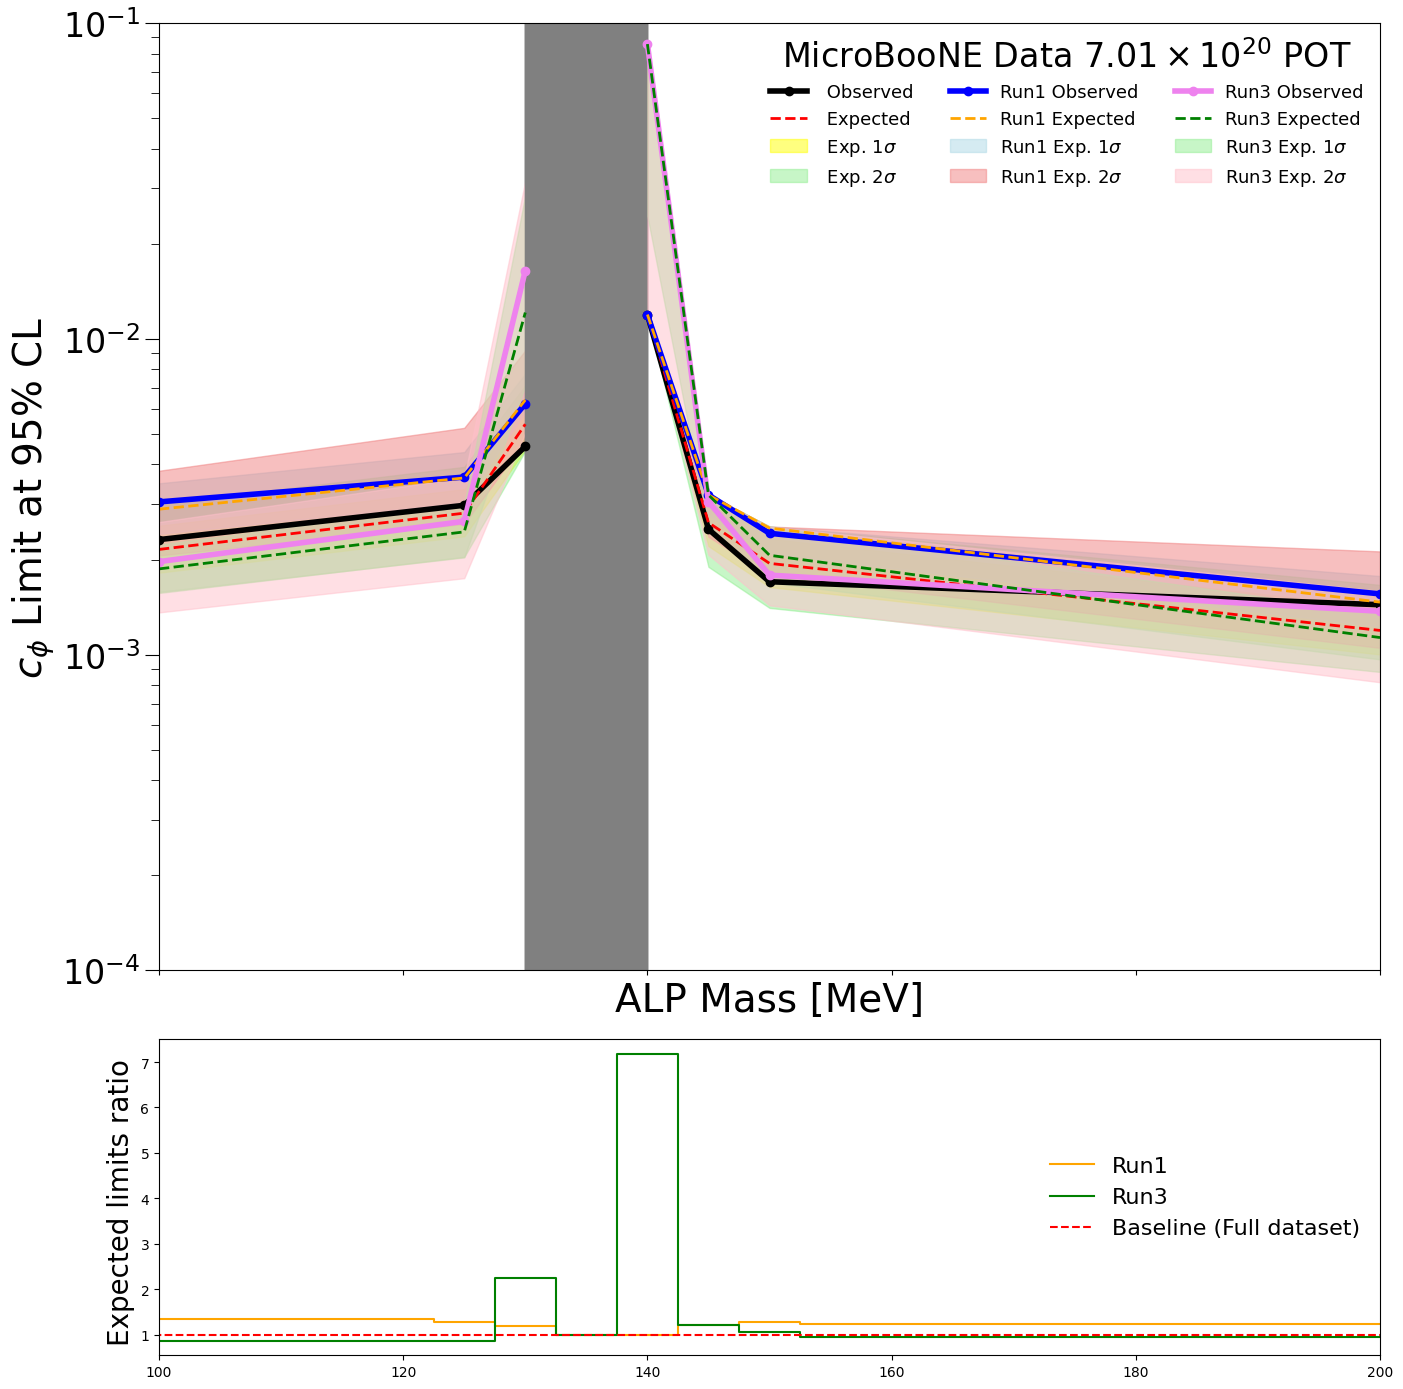

In [ ]:
data_comparisons = [
    ["ALL","Run1", "Run3"],
    ## Old limit files, do not exist on cluster
    # ["Test_ALL","TEST_KDIF","TEST_KDAR"],
    # ["Test_ALL", "TEST_1shr", "TEST_2shr"],
]

limit_to_compare = 'exp_limit'
    
for data_types in data_comparisons:
    compare_limits(data_types, limit_to_compare, skip_index=3)

In [ ]:
data_types = ["ALL","KDAR" ] 
limit_to_compare = 'exp_limit'
compare_limits(data_types, limit_to_compare)

### Can we roughly estimate what limits a $\mu^+\mu^-$ analysis would see?

Testing first with the limits we've already set, then move on to other HPS limits set by uboone

In [10]:
from scipy import optimize
LAMBDA = 1e6 # MeV, energy scale (1 TeV, used in https://arxiv.org/pdf/2202.03447.pdf)
hbar = 6.58211899e-22 # MeV⋅s

def parameter_optimization(x, theta, m_s):
    c_phi = np.abs(x)
    c_w = 0
    c_B = 0
    
    return (dw.decay_width_S_ee(theta,m_s) - dw.decay_width_a_yy(c_w,c_phi, c_B, m_s, LAMBDA) - dw.decay_width_a_ee(c_w,c_phi, c_B, m_s, LAMBDA))

def parameter_optimization(x, theta, m_s):
    tof = 1e-7
    m_a = m_s

    c_phi = np.abs(x)
    c_w = 0
    c_B = 0
    
    lambda_E = LAMBDA
    gamma_pi_a = dw.decay_width_pi_a(c_w, c_phi, c_B, m_a, lambda_E)
    gamma_pi_S = dw.decay_width_pi_S(theta, m_s)
    gamma_S = dw.decay_width_S_ee(theta, m_s)
    gamma_a = dw.decay_width_a_ee(c_w, c_phi, c_B, m_a, lambda_E) + dw.decay_width_a_yy(c_w, c_phi, c_B, m_a, lambda_E)
    gamma_a_ee = dw.decay_width_a_ee(c_w, c_phi, c_B, m_a, lambda_E)

    prod_ratio = gamma_pi_a/gamma_pi_S
    branching_ratio = gamma_a_ee/gamma_a
    
    return (gamma_a-gamma_S)/hbar

def get_reweighting(tof, m_s, theta, klong, starting_point = 1):
    m_a = m_s
    c_w = 0
    c_B = 0
    minimization = optimize.root(parameter_optimization, starting_point, args =(theta, m_s))
    # print(minimization)
    c_phi = minimization.x[0]
    rw = dw.reweighting(tof, m_s, theta, c_w, c_phi, c_B, klong=klong)

    lambda_E = LAMBDA
    gamma_pi_a = dw.decay_width_pi_a(c_w, c_phi, c_B, m_a, lambda_E)
    gamma_pi_S = dw.decay_width_pi_S(theta, m_s)

    gamma_pi0_a = dw.decay_width_pi0_a(c_w, c_phi, c_B, m_a, lambda_E)
    gamma_pi0_S = dw.decay_width_pi0_S(theta, m_s)

    gamma_S = dw.decay_width_S_ee(theta, m_s)
    gamma_a = dw.decay_width_a_ee(c_w, c_phi, c_B, m_a, lambda_E) + dw.decay_width_a_yy(c_w, c_phi, c_B, m_a, lambda_E)
    gamma_a_ee = dw.decay_width_a_ee(c_w, c_phi, c_B, m_a, lambda_E)

    diff_decay_width = (gamma_a-gamma_S)/hbar
    print(r"Decay width difference / hbar = {:.4} Hz".format(diff_decay_width))

    prod_ratio = gamma_pi_a/gamma_pi_S
    branching_ratio = gamma_a_ee/gamma_a
    return rw, c_phi


uboone_HPS = pd.read_csv(root_dir+"limit_files/Brazil_plot/obs_limit_ALL_Capped_HPS_rebinned_limit.csv",names=cols)


mass_c_phi_pairs = [[mass,c_phi] for mass,c_phi in zip(uboone_HPS['Mass'],uboone_HPS['Value'])]
mass_theta_pairs = [[mass,theta] for mass,theta in zip(uboone_HPS['Mass'],uboone_HPS['Value'])]

rw_matrix = []
wilson_phi_array = []
 
klong = True
rw_arr = []

for i, [mass_S, theta] in enumerate(mass_theta_pairs):
    theta = theta*10**-4
    temp = []
    mass_a = mass_S
    tof = 1e-7
    rw, c_phi = get_reweighting(tof, mass_S, theta, klong, starting_point=mass_c_phi_pairs[i][1])
    print(f"Mass = {mass_a}")


    gamma_S = dw.decay_width_S_ee(theta, mass_S)
    gamma_ll = dw.decay_width_a_ee(0, c_phi, 0, mass_a, LAMBDA)
    gamma_yy = dw.decay_width_a_yy(0, c_phi, 0, mass_a, LAMBDA)
    gamma_a = gamma_ll + gamma_yy
    print(f"Lepton decay width = {gamma_ll}\n Photon decay width = {gamma_yy}")
    print(f"c_phi = {c_phi}")
    print(f"Reweighting = {rw}")
    print()
    wilson_phi_array.append([mass_S,c_phi])
    rw_arr.extend([rw])
    rw_matrix.append([rw,c_phi])

Decay width difference / hbar = 8.72e-21 Hz
Mass = 100
Lepton decay width = 2.5808707375641696e-26
 Photon decay width = 2.922441891808013e-27
c_phi = 1.576138544138821e-07
Reweighting = 0.08991147318364648

Decay width difference / hbar = 0.0 Hz
Mass = 125
Lepton decay width = 8.298811457333944e-27
 Photon decay width = 1.5575155046532104e-26
c_phi = 7.993925979491359e-08
Reweighting = 0.013464417515736168

Decay width difference / hbar = 0.0 Hz
Mass = 130
Lepton decay width = 2.016423468805037e-27
 Photon decay width = 1.6270062882201413e-26
c_phi = 3.863899555389783e-08
Reweighting = 0.0013549088508636592

Decay width difference / hbar = -8.72e-21 Hz
Mass = 135
Lepton decay width = 5.230271315452591e-32
 Photon decay width = 2.0883854293371443e-26
c_phi = 1.9310849067743638e-10
Reweighting = 6.9893055772082e-13

Decay width difference / hbar = -1.744e-20 Hz
Mass = 140
Lepton decay width = 1.8842196536050053e-27
 Photon decay width = 1.7368447942038186e-26
c_phi = 3.599212222715813e-

In [14]:
def scale_limits(limits, weights):
    return limits/np.sqrt(weights)

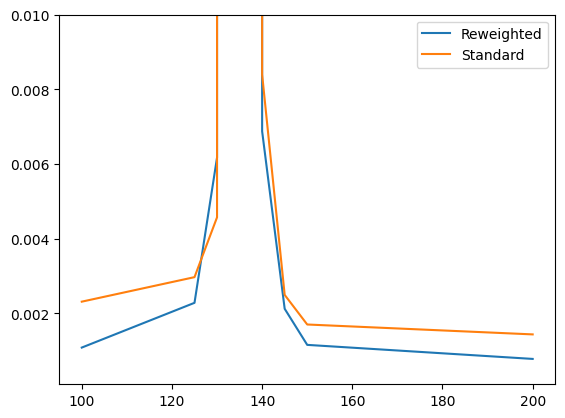

In [19]:
rw_arr= np.array(rw_arr)
plt.plot(uboone_HPS['Mass'],scale_limits(uboone_HPS['Value'],rw_arr),label='Reweighted')
plt.plot(uboone_ALP['Mass'],uboone_ALP['Value'],label='Standard')
# plt.yscale('log')
plt.ylim(1e-4,1e-2)
plt.legend()

### Rough reweighting of HPS $\mu^+\mu^-$

note that based on the last figure, we're over estimating our sensitivity here

In [29]:
2.0/0.7

2.857142857142857

In [ ]:
uboone_mumu_HPS = pd.read_csv(root_dir+"limit_files/uboone_mumu_theta2.csv",names=cols)
uboone_mumu_HPS["Value"] = np.sqrt(uboone_mumu_HPS["Value"])

mass_c_phi_pairs = [[mass,c_phi] for mass,c_phi in zip(uboone_mumu_HPS['Mass'],uboone_mumu_HPS['Value'])]
mass_theta_pairs = [[mass,theta] for mass,theta in zip(uboone_mumu_HPS['Mass'],uboone_mumu_HPS['Value'])]

rw_matrix = []
wilson_phi_array = []
 
klong = True
rw_arr = []

for i, [mass_S, theta] in enumerate(mass_theta_pairs):
    theta = theta*10**-4
    temp = []
    mass_a = mass_S
    tof = 1e-7
    rw, c_phi = get_reweighting(tof, mass_S, theta, klong, starting_point=mass_c_phi_pairs[i][1])
    print(f"Mass = {mass_a}")


    gamma_S = dw.decay_width_S_ee(theta, mass_S)
    gamma_ll = dw.decay_width_a_ee(0, c_phi, 0, mass_a, LAMBDA)
    gamma_yy = dw.decay_width_a_yy(0, c_phi, 0, mass_a, LAMBDA)
    gamma_a = gamma_ll + gamma_yy
    print(f"Lepton decay width = {gamma_ll}\n Photon decay width = {gamma_yy}")
    print(f"c_phi = {c_phi}")
    print(f"Reweighting = {rw}")
    print()
    wilson_phi_array.append([mass_S,c_phi])
    rw_arr.extend([rw])
    rw_matrix.append([rw,c_phi])

Decay width difference / hbar = 8.929e-18 Hz
Mass = 211.4942528735632
Lepton decay width = 3.31405715716966e-24
 Photon decay width = 2.4480140948579386e-24
c_phi = 1.228098410885448e-06
Reweighting = 0.036862651101763295

Decay width difference / hbar = 5.581e-18 Hz
Mass = 211.4942528735632
Lepton decay width = 2.5235783861055093e-24
 Photon decay width = 1.8641064911328174e-24
c_phi = 1.0716712298495223e-06
Reweighting = 0.03686265110176329

Decay width difference / hbar = 3.907e-18 Hz
Mass = 211.4942528735632
Lepton decay width = 1.5664488109332276e-24
 Photon decay width = 1.157097957632384e-24
c_phi = 8.443281635499561e-07
Reweighting = 0.0368626511017633

Decay width difference / hbar = 2.232e-18 Hz
Mass = 211.4942528735632
Lepton decay width = 8.484847050358256e-25
 Photon decay width = 6.267551881854118e-25
c_phi = 6.214056264895922e-07
Reweighting = 0.0368626511017633

Decay width difference / hbar = 1.395e-18 Hz
Mass = 211.4942528735632
Lepton decay width = 6.461016092995169e

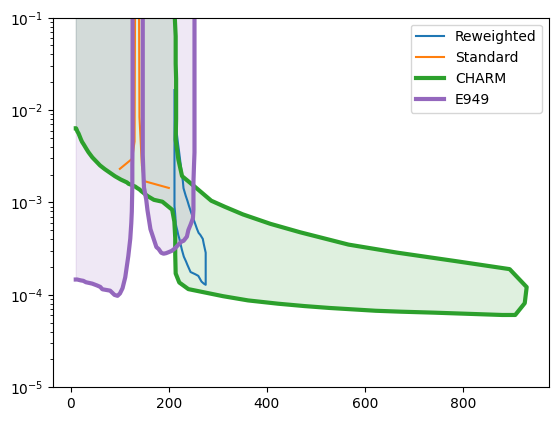

In [28]:
rw_arr= np.array(rw_arr)
plt.plot(uboone_mumu_HPS['Mass'],scale_limits(uboone_mumu_HPS['Value'],rw_arr),label='Reweighted')
plt.plot(uboone_ALP['Mass'],uboone_ALP['Value'],label='Standard')

plt.plot(charm_beam_dump_1GeV['Mass']*1000,charm_beam_dump_1GeV['Value'],label=r"CHARM",color="C2",lw=3)
plt.fill_between(charm_beam_dump_1GeV['Mass']*1000,charm_beam_dump_1GeV['Value'], 1, color="C2",alpha=0.15)

plt.plot(e949_100MeV['Mass']*1000,e949_100MeV['Value'],label=r"E949",color="C4",lw=3)
plt.fill_between(e949_100MeV['Mass']*1000,e949_100MeV['Value'],1,color="C4",alpha=0.15)

plt.plot(e949_150MeV['Mass']*1000,e949_150MeV['Value'],color="C4",lw=3)
plt.fill_between(e949_150MeV['Mass']*1000,e949_150MeV['Value'],1,color="C4",alpha=0.15)

plt.yscale('log')
plt.ylim(1e-5,1e-1)
plt.legend()

## Logarithmic interpolating